# Wet dry model intercomparison

The target of this notebook is to compare several algorithms from PyNNCML and pycomlink on open datasets using poligrain.

## Imports

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as skl

# Poligrain for example data
import poligrain as plg

In [2]:
# include local submodules as packages
for submodule_name in ['PyNNcml',"pycomlink","cml_wd_telcosense"]:
    sys.path.append(os.path.join(os.getcwd(), submodule_name))
    
from pynncml.cml_methods.apis.xarray_processing.wet_dry_methods import create_wet_dry_std
from pycomlink.processing.pytorch_utils.run_inference import cnn_wd
from pycomlink.processing.tensorflow_utils import run_inference
import telcosense_classification.metrics_utility as metrics

# Other methods to be tested?
#from pycomlink.processing.wet_dry import nearby_wet_dry
#from pycomlink.processing.wet_dry import mlp
#from pynncml.cml_methods.apis.xarray_processing.wet_dry_methods import create_wet_dry_dnn_gru


c:\Users\lukas\Documents\OpenSense\bench-deep-cml\PyNNcml\pynncml\model_zoo\model_common.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
c:\Users\lukas\miniforge3\envs\bench-deep-cml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load OpenMRG Dataset

In [3]:
# OpenMRG Dataset from Poligrain
( ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi) = plg.example_data.load_openmrg(data_dir="example_data", subset="8d")


File already exists at example_data\openmrg_cml_8d.nc
Not downloading!
File already exists at example_data\openmrg_rad_8d.nc
Not downloading!
File already exists at example_data\openmrg_municp_gauge_8d.nc
Not downloading!
File already exists at example_data\openmrg_smhi_gauge_8d.nc
Not downloading!


### Create rainrate and wet dry reference for cmls from radar data

DONT use R from CML dataset  
Calculate R from radar product using Poligrain  

<span style="color:red">Important issues to resolve in future for accurate results:</span>

TODO: Time agregation: dont upsample R, 5 or 15 minute classification step is optimal, upsampling data includes artificial data. 

TODO: All models should be trained and refined for the same classification step. 

TODO: Investigate R and tl timeseries non-alignment (delays) by performing crosscorrelation (other methods?).


In [4]:
# Assign coordinates to the cml dataset
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, "EPSG:32632"
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, "EPSG:32632"
)

ds_cmls.coords["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls.coords["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2

In [5]:
# Calculate intersect weights and get radar time series at CML locations
da_intersect_weights = plg.spatial.calc_sparse_intersect_weights_for_several_cmls(
    x1_line=ds_cmls.site_0_lon.values,
    y1_line=ds_cmls.site_0_lat.values,
    x2_line=ds_cmls.site_1_lon.values,
    y2_line=ds_cmls.site_1_lat.values,
    cml_id=ds_cmls.cml_id.values,
    x_grid=ds_rad.lon.values,
    y_grid=ds_rad.lat.values,
    grid_point_location='center',
)
da_radar_along_cmls = plg.spatial.get_grid_time_series_at_intersections(
    grid_data=ds_rad.R,
    intersect_weights=da_intersect_weights,
)

ds_radar_along_cmls=da_radar_along_cmls.to_dataset(name='R')

# Optional: save radar along cml data
#ds_radar_along_cmls.to_netcdf('data/andersson_2022_OpenMRG/radar/radar_along_cml.nc

<span style="color:red">Warning: reference radar R is upsampled to 10 seconds</span>  

Change it back to keep R period to 5min, and rather downsample cml data 

In [6]:
# Resample radar to 10s and forward fill
ds_radar_along_cmls = ds_radar_along_cmls.resample(time='10s', label='right', closed='right').ffill()

# convert from mm/5min to mm/10s
ds_radar_along_cmls = ds_radar_along_cmls/30


In [7]:
# remove original cml rainrate variable 
ds_cmls = ds_cmls.drop_vars('R')

# Last 29 time steps will have no reference R from radar, after resampling radar
ds_cmls = ds_cmls.drop_isel(time=[range(-30,-1)])

# Add radar R rainrate along cmls to cml dataset
ds_cmls['R'] = ds_radar_along_cmls.R

# Ensure the first and last time steps are dry
ds_cmls['R'][[0,-1],:] = 0

# Create binary reference wet/dry variable from radar rainrate
ds_cmls['ref_wd'] = ds_cmls.R.where(ds_cmls.R <= 0.1, True).astype(bool)


__CML preprocessing__

In [8]:
# CML Preprocessing: Remove outliers, compute tl and interpolate missing values
ds_cmls['tsl'] = ds_cmls.tsl.where(ds_cmls.tsl != 255.0)
ds_cmls['rsl'] = ds_cmls.rsl.where(ds_cmls.rsl != -99.9)
ds_cmls['tl'] = ds_cmls.tsl - ds_cmls.rsl # calculate total loss (previous TRSL)
ds_cmls['tl'] = ds_cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

In [9]:
# TEMPORARY: select only few CMLs to save memory
ds_cmls = ds_cmls.isel(cml_id = [0]) #range(0,10)) #

## Methods inference
___  
### A: Wet Dry Classification using Std from PyNNCML

In [10]:
std_threshold = 0.2

# Replaced STD Wet/Dry classification from PyNNCML with direct rolling std
ds_cmls['std_pred'] = ds_cmls.tl.rolling(time=60, center=True).std()
ds_cmls['std_wd'] = ds_cmls.tl.rolling(time=60, center=True).std() > std_threshold


# Run STD Wet/Dry classification from PyNNCML
'''
wd_std=create_wet_dry_std(threshold=std_threshold)
std_wet_dry = wd_std(ds_cmls)

ds_cmls['std_wd'] = std_wet_dry.wet_dry_detection
'''

"\nwd_std=create_wet_dry_std(threshold=std_threshold)\nstd_wet_dry = wd_std(ds_cmls)\n\nds_cmls['std_wd'] = std_wet_dry.wet_dry_detection\n"

___  
### B: Wet Dry Classification using Pycomlink PyTorch CNN, Polz_2020

In [11]:
# Ensure, the TL dataarray shape is (time, channels, cml_id)
tl = ds_cmls.tl.transpose('time', 'sublink_id', 'cml_id')

# Normalisation
tl_normed = tl - tl.median(dim='time')

In [12]:
# CNN inference
model_URL = "https://github.com/jpolz/cml_wd_pytorch/raw/be2b15fa987838ea1f709dd0180917eebf66271a/data/dummy_model/best_model_jit.pt"
cnn_torch_wet_dry = cnn_wd(model_URL,data=tl_normed)

# Create binary wet/dry classification from probabilistic output
cnn_torch_threshold = 0.5
ds_cmls['cnn_torch_pred'] = (('time','cml_id'), cnn_torch_wet_dry.predictions.values)
ds_cmls['cnn_torch_wd'] = (('time','cml_id'), cnn_torch_wet_dry.predictions.values > cnn_torch_threshold)

Using cached model at C:\Users\lukas\.cml_wd_pytorch\models\model_82cadc59c69484be44b1bd4226e1afe4.pt
✅ Loaded exported model from: C:\Users\lukas\.cml_wd_pytorch\models\model_82cadc59c69484be44b1bd4226e1afe4.pt


___  
### C: Wet Dry Classification using Pycomlink TensorFlow CNN,

In [13]:
# Separating TL channels into separate data variables to match the tensorflow model input
ds_cmls["tl1"] = ds_cmls["tl"].sel(sublink_id = 'sublink_1')
ds_cmls["tl2"] = ds_cmls["tl"].sel(sublink_id = 'sublink_2')

In [ ]:
# MemoryError: Unable to allocate 32.7 GiB for an array with shape (24365590, 180, 2) and data type float32
# TODO: The tensorflow model needs memory allocation for whola dataloader, for testing, we select only a subset of the data... TODO: Needs to resolved
cnn_tensf_wet_dry = run_inference.wet_dry_1d_cnn(ds=ds_cmls, return_ds=False)

[⚠️] TensorFlow is using CPU.
[→] Using cached file: c:\Users\lukas\Documents\OpenSense\bench-deep-cml\model_cnn\CNN__model_v0_cz.json
[→] Using cached file: c:\Users\lukas\Documents\OpenSense\bench-deep-cml\model_cnn\CNN__model_v0_cz.weights.h5


c:\Users\lukas\miniforge3\envs\bench-deep-cml\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


[✓] Model loaded and compiled.
535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


Storing predictions (model): 100%|██████████| 1/1 [00:00<?, ?CML/s]


In [15]:
cnn_tensf_threshold = 0.5
ds_cmls['cnn_tensf_pred'] = cnn_tensf_wet_dry
ds_cmls['cnn_tensf_wd'] = cnn_tensf_wet_dry > cnn_tensf_threshold

### D: cml_wd_telcosense model inference

In [29]:
# TODO: Add cml_wd_telcosense model inference

## Result comparison
___  
### Plot the prediction outputs

In [ ]:
# minor todos: 
# TODO: unify plot for all methods

# TODO: Rebuild the dictionaries int one dict:
"""
method_out_dict = {
    'STD': {
        'prediction': cml.isel(sublink_id=0).std_pred.values,
        'wet_dry': cml.isel(sublink_id=0).std_wd.values,
        'threshold': std_threshold
    },
    'CNN Pycomlink Torch': {
        'prediction': cml.cnn_torch_pred.values,
        'wet_dry': cml.cnn_torch_wd.values,
        'threshold': cnn_torch_threshold
    },
    'CNN Pycomlink TensorFlow': {
        'prediction': cml.cnn_tensf_pred.values,
        'wet_dry': cml.cnn_tensf_wd.values,
        'threshold': cnn_tensf_threshold
    }
    #... other methods
}

"""

# TODO? Optionally unify the dict for all output data and metrics: plots, ROC, CM, ACC, MCC etc.

"""
compare_methods_dict = {
    'STD': {
        # ... same as below
    },
    'CNN Pycomlink Torch': {
        'prediction': cml.cnn_torch_pred.values,
        'wet_dry': cml.cnn_torch_wd.values,
        'threshold': cnn_torch_threshold
        'roc': metrics.calculate_roc_curve(cmlcml.cnn_torch_pred.values, ref_wd, 0, 1),
        'confusion_matrix': skl.confusion_matrix(ref_wd, cml.cnn_torch_wd.values, labels=[1,0], normalize='true').round(decimals=4),
        'ACC': np.round(skl.accuracy_score(ref_wd, cml.cnn_torch_wd),decimals=4),
        'MCC': np.round(skl.matthews_corrcoef(ref_wd, cml.cnn_torch_wd),decimals=4),
        'F1': np.round(skl.f1_score(ref_wd, cml.cnn_torch_wd),decimals=4)
    },    
    #... other methods
}

"""


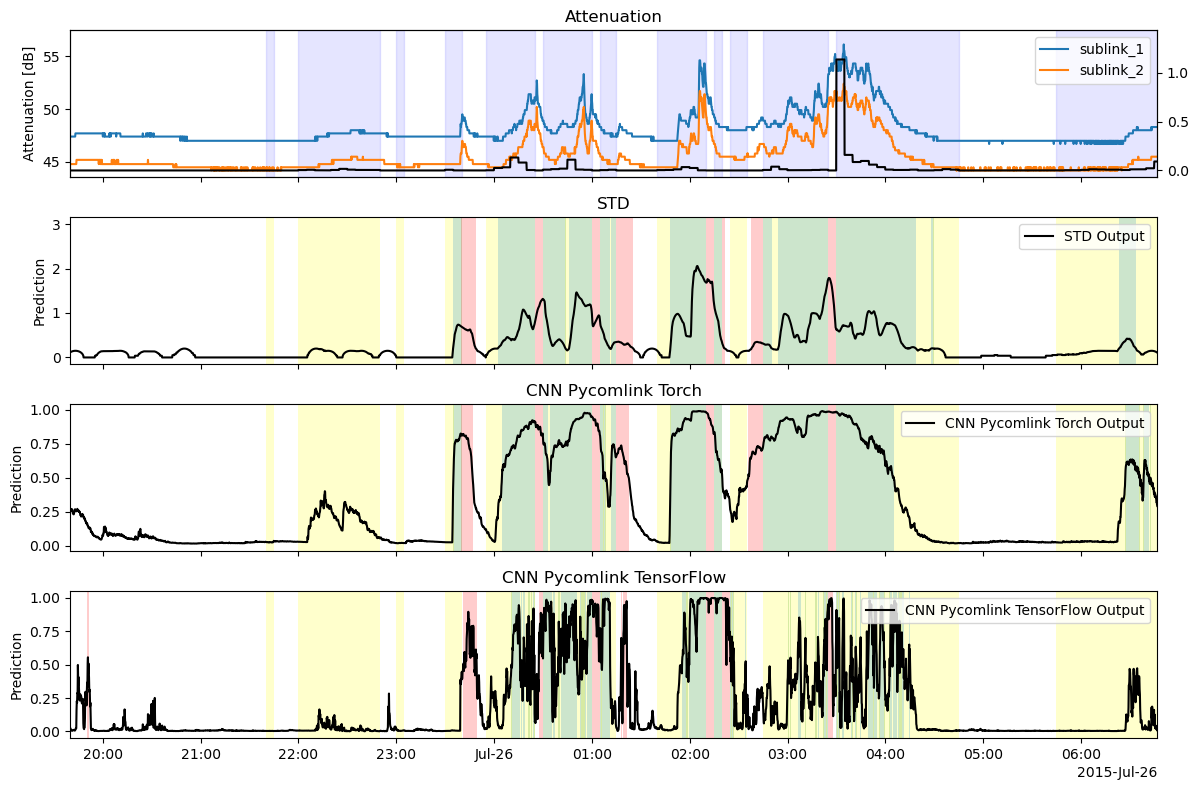

In [27]:
# Select CML index to plot
cml_id = 0 


cml = ds_cmls.isel(cml_id=cml_id)
ref_wd = cml.ref_wd.values.astype(bool)

# Dictionaries of method names, prediction outputs and wet/dry classifications
outputs = {
    'STD': cml.std_pred.isel(sublink_id=0), 
    'CNN Pycomlink Torch': cml.cnn_torch_pred,
    'CNN Pycomlink TensorFlow': cml.cnn_tensf_pred,
    # add your new method here... 'method_name': output_dataarray
}
wetdry = {
    'STD': cml.isel(sublink_id=0).std_wd.values.astype(bool),
    'CNN Pycomlink Torch': cml.cnn_torch_wd.values.astype(bool),
    'CNN Pycomlink TensorFlow': cml.cnn_tensf_wd.values.astype(bool),
    # add your new method here... 'method_name': wet_dry_array.astype(bool)
}

fig, axs = plt.subplots(nrows=len(outputs)+1, figsize=(12,2*(len(outputs)+1)), sharex=True)

# First subplot: attenuation
cml.tl.plot.line(x='time', ax=axs[0], label=cml.sublink_id.values)
axs[0].set_ylabel('Attenuation [dB]')
axs[0].set_xlabel('')
axs[0].set_title('Attenuation')
axs[0].legend(loc='upper right')

# Get start and end of dry event
wet_start = np.roll(cml.ref_wd, -1) & ~cml.ref_wd
wet_end = np.roll(cml.ref_wd, 1) & ~cml.ref_wd
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[0].axvspan(cml.time.values[wet_start_i], cml.time.values[wet_end_i], color='b', alpha=0.1)

# Plot reference rain rate on secondary y-axis
ax_rain = axs[0].twinx()
ax_rain.plot(cml.time.values, ds_cmls.R.isel(cml_id=cml_id), color='black', label='gauge Rain rate [mm]')


# Subplots: prediction outputs with shaded TP/FN/FP
for idx, (name, wd) in enumerate(wetdry.items(), start=1):
    outputs[name].plot.line(x='time', ax=axs[idx], label=f'{name} Output', color='black')
    #axs[idx].axhline(cnn_tensf_threshold, color='k', linestyle='--')         # plot the threshold line
    axs[idx].set_ylabel('Prediction')
    axs[idx].set_title(name)
    axs[idx].set_xlabel('')
    axs[idx].legend(loc='upper right')

    # Create TP, FN, FP masks 
    TP = wd & ref_wd
    FN = ~wd & ref_wd
    FP = wd & ~ref_wd
    # Ensure their first and last values are False
    TP[0] = TP[-1] = False
    FN[0] = FN[-1] = False
    FP[0] = FP[-1] = False

    for flag, color in zip([TP, FN, FP], ['green', 'yellow', 'red']):
        start = np.roll(flag, -1) & ~flag
        end = np.roll(flag, 1) & ~flag
        for start_i, end_i in zip(
            start.nonzero()[0],
            end.nonzero()[0],
        ):
            axs[idx].axvspan(cml.time.values[start_i], cml.time.values[end_i], color=color, alpha=0.2,linewidth=0)
    
    
[ax.set_xlim(cml.time[33000], cml.time[37000]) for ax in axs] 
#[ax.set_xlim(cml.time[0], cml.time[-1]) for ax in axs]    # Fit x scale to full plot width

plt.xlabel('Time')
plt.tight_layout()
plt.show()


___
### Performance metrics


TODO: Other intercomparison metrics: ACC, Correction Matrix, MCC, F1-score, ROC-AUC, 
Common metrics for binary classifier comparison:
- Accuracy (ACC)
- Confusion Matrix
- Precision
- Recall (Sensitivity, True Positive Rate)
- Specificity (True Negative Rate)
- F1-score
- Matthews Correlation Coefficient (MCC)
- ROC Curve and Area Under Curve (ROC-AUC)
- Precision-Recall Curve and AUC
- Balanced Accuracy
- Cohen's Kappa


__Plot ROC curves__

TODO: Add ROC curves for all different cmls, to see outliers and spread etc.

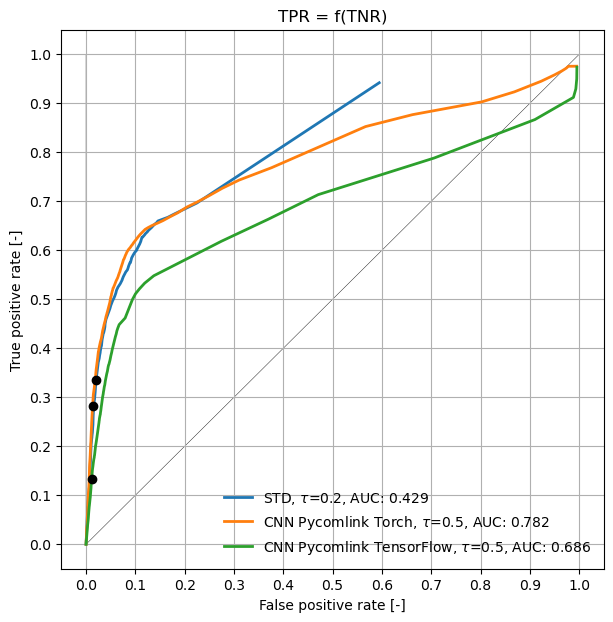

In [21]:
# Add all methods prediction model names, outputs and used thresholds into a dictionary
roc_dict = {
    'STD': {
        'roc': metrics.calculate_roc_curve(cml.isel(sublink_id=0).std_pred.values, ref_wd, 0, 1),
        'threshold': std_threshold
    },
    'CNN Pycomlink Torch': {
        'roc': metrics.calculate_roc_curve(cml.cnn_torch_pred.values, ref_wd, 0, 1),
        'threshold': cnn_torch_threshold
    },
    'CNN Pycomlink TensorFlow': {
        'roc': metrics.calculate_roc_curve(cml.cnn_tensf_pred.values, ref_wd, 0, 1),
        'threshold': cnn_tensf_threshold
    }
}
# Calculate the area under ROC curve
#roc_a_cnn = metrics.calculate_roc_surface(roc_cnn)

metrics.plot_roc_curve(roc_dict)

normalized confusion matrix:
 [[0.281 0.719]
 [0.013 0.987]]
TPR: 0.281
TNR: 0.987


c:\Users\lukas\Documents\OpenSense\bench-deep-cml\cml_wd_telcosense\telcosense_classification\metrics_utility.py:143: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([''] + labels)
c:\Users\lukas\Documents\OpenSense\bench-deep-cml\cml_wd_telcosense\telcosense_classification\metrics_utility.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([''] + labels)


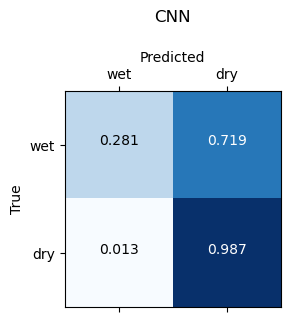

MCC: 0.429
ACC: 0.841
F1: 0.422


In [ ]:
# confusion matrix for CNN Pycomlink Torch
cm = skl.confusion_matrix(ref_wd, cml.cnn_torch_wd.values, labels=[1,0], normalize='true').round(decimals=3)
print('normalized confusion matrix:\n',cm)
print('TPR:', cm[0,0])
print('TNR:', cm[1,1])
metrics.plot_confusion_matrix(cm)

# Matthews Correlation Coeficient
mcc = np.round(skl.matthews_corrcoef(ref_wd, cml.cnn_torch_wd),decimals=3)
print('MCC:', mcc)

# ACC 
acc = np.round(skl.accuracy_score(ref_wd, cml.cnn_torch_wd),decimals=3)
print('ACC:', acc)

f1 = np.round(skl.f1_score(ref_wd, cml.cnn_torch_wd),decimals=3)
print('F1:', f1)

normalized confusion matrix:
 [[0.134 0.866]
 [0.012 0.988]]
TPR: 0.134
TNR: 0.988


c:\Users\lukas\Documents\OpenSense\bench-deep-cml\cml_wd_telcosense\telcosense_classification\metrics_utility.py:143: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([''] + labels)
c:\Users\lukas\Documents\OpenSense\bench-deep-cml\cml_wd_telcosense\telcosense_classification\metrics_utility.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([''] + labels)


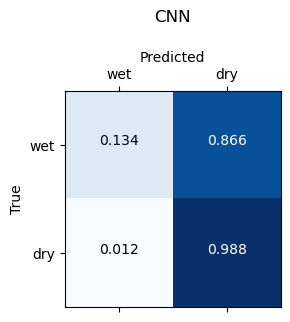

MCC: 0.263
ACC: 0.812
F1: 0.228


In [ ]:
# confusion matrix for tensorflow model
cm = skl.confusion_matrix(ref_wd, cml.cnn_tensf_wd.values, labels=[1,0], normalize='true').round(decimals=3)
print('normalized confusion matrix:\n',cm)
print('TPR:', cm[0,0])
print('TNR:', cm[1,1])
metrics.plot_confusion_matrix(cm)

# Matthews Correlation Coeficient
mcc = np.round(skl.matthews_corrcoef(ref_wd, cml.cnn_tensf_wd),decimals=3)
print('MCC:', mcc)

# ACC 
acc = np.round(skl.accuracy_score(ref_wd, cml.cnn_tensf_wd),decimals=3)
print('ACC:', acc)

f1 = np.round(skl.f1_score(ref_wd, cml.cnn_tensf_wd),decimals=3)
print('F1:', f1)